In [1]:
import numpy as np
import pandas as pd

from plotnine import *
from sklearn.metrics import precision_recall_curve

In [2]:
n = 500
m = 100

y_true = np.repeat([0, 1], n // 2)
y_scores = [np.random.permutation(np.linspace(0, 1, num=n)) for _ in range(m)]
y_scores_rigged = [np.concatenate((np.zeros(n // 10), np.random.permutation(np.linspace(0, 1, num=8 * n // 10)), np.ones(n // 10)))
                   for _ 
                   in range(m)]

In [3]:
curves = [precision_recall_curve(y_true, y_score) for y_score in y_scores]
curves_rigged = [precision_recall_curve(y_true, y_score) for y_score in y_scores_rigged]

In [4]:
grid = np.linspace(0, 1)

interps = [np.interp(x=grid, xp=r[::-1], fp=p)[::-1] for p, r, _ in curves]
interp_q = np.quantile(interps, q=0.9, axis=0)

grid_2 = np.linspace(0.2, 1)
interps_rigged = [np.interp(x=grid_2, xp=r[::-1], fp=p)[::-1] for p, r, _ in curves_rigged]
interp_rigged_q = np.quantile(interps_rigged, q=0.9, axis=0)

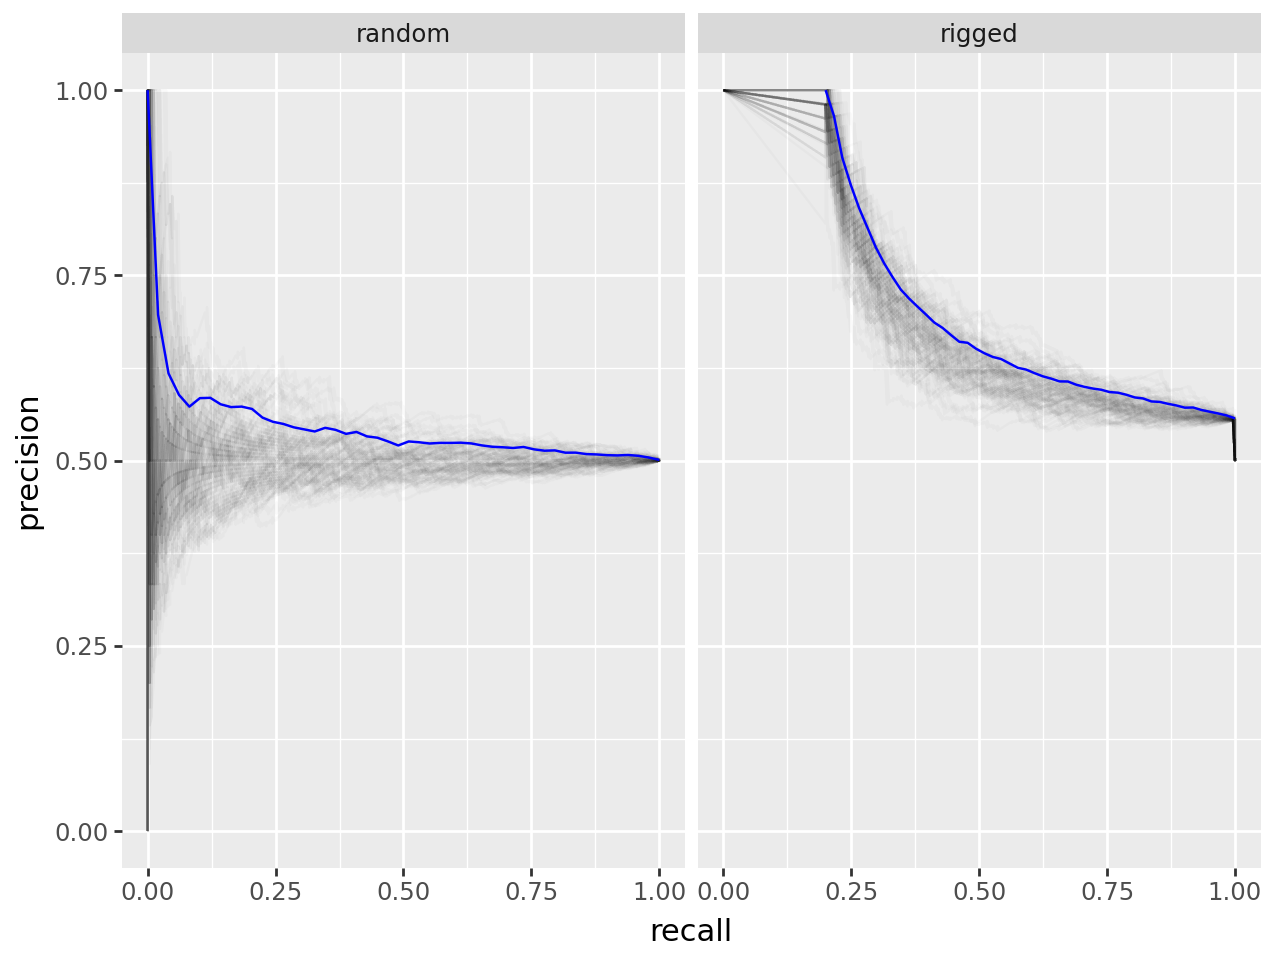

In [5]:
dfs = [pd.DataFrame({'precision': p, 'recall': r, 'group': i, 'model': 'random'}) for i, (p, r, _) in enumerate(curves)]
dfs += [pd.DataFrame({'precision': p, 'recall': r, 'group': i, 'model': 'rigged'}) for i, (p, r, _) in enumerate(curves_rigged)]
df_interp_q = pd.DataFrame({'grid': grid, 'interp': interp_q, 'model': 'random'})
df_interp_rigged_q = pd.DataFrame({'grid': grid_2, 'interp': interp_rigged_q, 'model': 'rigged'})

g = ggplot() + facet_wrap('model')
g = g + geom_line(aes('recall', 'precision', group='group'), data=pd.concat(dfs), alpha=2/m)
g = g + geom_line(aes('grid', 'interp'), color='blue', data=pd.concat([df_interp_q, df_interp_rigged_q]))
g

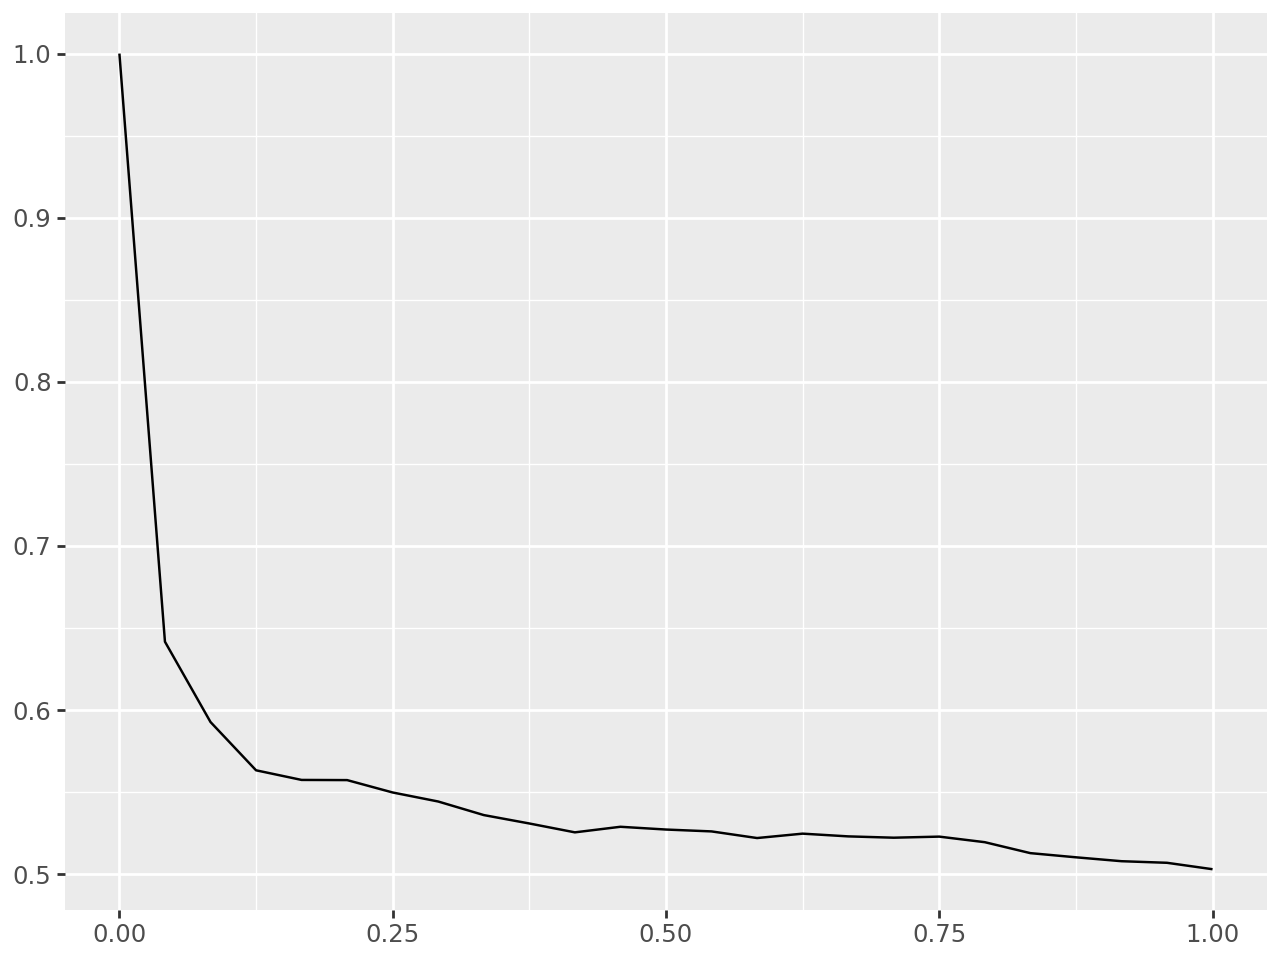

In [69]:
def __bias_score(y_true, y_score, bias):
    n = int(y_true.shape[0] * bias / 2)

    y_score = np.random.permutation(y_score)

    neg = np.random.choice(np.flatnonzero(y_score < 0.5), n)
    pos = np.random.choice(np.flatnonzero(y_score >= 0.5), n)

    ineg = np.random.choice(np.flatnonzero(y_true == 0), n)
    ipos = np.random.choice(np.flatnonzero(y_true == 1), n)

    y_score[ineg], y_score[ipos] = y_score[neg], y_score[pos]

    return y_score


def simulate(n_samp, n_sim, ppos, bias):
    n_pos = ppos * n_samp
    
    y_true = np.repeat((0, 1), (n_samp - n_pos, n_pos))
    init_scores = np.tile(np.linspace(0, 1, num=n_samp), n_sim) \
                    .reshape((n_sim, n_samp))

    y_scores = np.apply_along_axis(lambda s: __bias_score(y_true, s, bias), 
                                   arr=init_scores,
                                   axis=-1)

    return y_true, y_scores


def curves(y_true, y_scores):
    return [precision_recall_curve(y_true, y_s)[:2]
            for y_s
            in y_scores]


def __decreasing(p, r):
    idx = np.flip(np.diff(r[::-1], prepend=1.1) > 0)
    return p[idx], r[idx]
    

def quantile(curves, q, n_knots=25):
    knots = np.linspace(0, 1, num=n_knots)
    dec = [__decreasing(p, r) for p, r in curves]
    interps = [np.interp(knots, xp=r[::-1], fp=p)[::-1] for p, r in dec]
    return knots, np.quantile(interps, q=q, axis=0)


def f(n_samp, n_sim, ppos, bias, q):
    y_true, y_scores = simulate(n_samp, n_sim, ppos, bias)
    c = curves(y_true, y_scores)
    return quantile(c, q)


x, y = f(n, m, ppos=0.5, bias=0.0, q=0.9)
g = ggplot() + aes(x, y) + geom_line()
g